In [2]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
import scipy.stats as sista
import statsmodels.api as sm
from statsmodels.formula.api import ols

np.random.seed(42)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
output_dir = Path('./output')
fig_dir = output_dir / 'figures' / 'behavior'

behavior = None
experiment_names = ['1801','1901','1902']
for iexp,experiment_name in enumerate(experiment_names):
    
    data_dir = f'./data/{experiment_name}'
    exp = decode_eeg.Experiment(experiment_name,data_dir,test=False)
    
    for isub in range(exp.nsub):
        # Load subject's behavior data
        if behavior is None:
            behavior = pd.DataFrame(exp.load_behavior(isub))[['Subject','TrialType','ACC','SetSize','Timestamp']]
            behavior['Experiment'] = (np.ones(len(behavior))*iexp).astype(int)
        else:
            temp = pd.DataFrame(exp.load_behavior(isub))[['Subject','TrialType','ACC','SetSize','Timestamp']]
            temp['Experiment'] = (np.ones(len(temp))*iexp).astype(int)
            behavior = behavior.append(temp)

behavior.tail()

,Subject,TrialType,ACC,SetSize,Timestamp,Experiment
1074,20,1,1,1,1579734021,2
1075,20,1,1,1,1579734027,2
1076,20,1,1,4,1579734033,2
1077,20,1,1,3,1579734038,2
1078,20,1,1,1,1579734060,2


In [12]:
total_means = behavior.groupby(['Experiment','SetSize'])['ACC'].mean()
subject_means = behavior.groupby(['Experiment','SetSize','Subject'])['ACC'].mean().reset_index()
total_means

Experiment  SetSize
0           1          0.917015
            2          0.888095
            3          0.835514
            4          0.762686
1           1          0.966280
            2          0.917102
            3          0.832606
            4          0.756411
2           1          0.965916
            2          0.903212
            3          0.801378
            4          0.723733
Name: ACC, dtype: float64

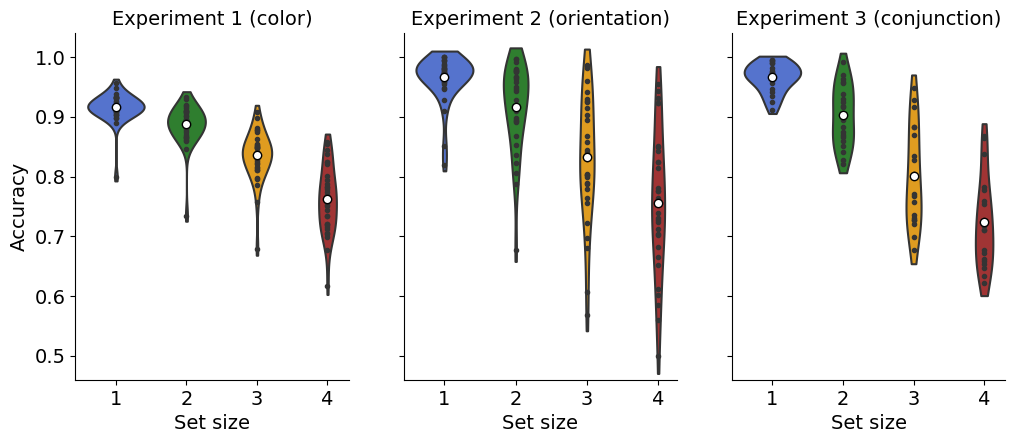

In [19]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12,4.5))
# fig.suptitle('Change detection accuracy',fontsize=18)
my_pal = {"royalblue", "firebrick", "forestgreen", "orange"}

# experiment 1
sns.violinplot(
    ax = axes[0], 
    x='SetSize',y='ACC', 
    data=subject_means[subject_means['Experiment']==0],
    dodge=True,inner='points',cut=.5,palette = my_pal)

axes[0].set_title('Experiment 1 (color)',fontsize=14)

# experiment 2
sns.violinplot(
    ax = axes[1], 
    x='SetSize',y='ACC', 
    data=subject_means[subject_means['Experiment']==1],
    dodge=True,inner='points',cut=.5,palette = my_pal) 

axes[1].set_title('Experiment 2 (orientation)',fontsize=14)

# experiment 3
sns.violinplot(
    ax = axes[2], 
    x='SetSize',y='ACC', 
    data=subject_means[subject_means['Experiment']==2],
    dodge=True,inner='points',cut=.5,palette = my_pal) 

axes[2].set_title('Experiment 3 (conjunction)',fontsize=14)

for iax,ax in enumerate(axes):

    # plot means
    ax.scatter(
        x = [0,1,2,3],
        y = [total_means[iax][1],total_means[iax][2],total_means[iax][3],total_means[iax][4]],
        c = 'white', edgecolors='k')

    # asethetics
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel('Set size',fontsize=14)
    if iax == 0:
        ax.set_ylabel('Accuracy',fontsize=14)
    else:
        ax.set_ylabel('')
plt.ylim([.46,1.04])
plt.savefig('output/figures/cd_accuracy.png',dpi=500,bbox_inches='tight')
plt.savefig('output/figures/cd_accuracy.pdf',dpi=500,bbox_inches='tight')
plt.show()

In [14]:
model_exp1 = ols('ACC ~ C(SetSize)', data=subject_means.loc[subject_means['Experiment']==0]).fit();
anova_table_exp1 = sm.stats.anova_lm(model_exp1, typ=1);
anova_table_exp1

,df,sum_sq,mean_sq,F,PR(>F)
C(SetSize),3.0,0.451782,0.150594,90.191793,2.015141e-31
Residual,128.0,0.213723,0.001670,NaN,NaN


In [15]:
model_exp2 = ols('ACC ~ C(SetSize)', data=subject_means.loc[subject_means['Experiment']==1]).fit();
anova_table_exp2 = sm.stats.anova_lm(model_exp2, typ=1);
anova_table_exp2

,df,sum_sq,mean_sq,F,PR(>F)
C(SetSize),3.0,0.788738,0.262913,32.927262,1.336688e-15
Residual,120.0,0.958158,0.007985,NaN,NaN


In [16]:
model_exp3 = ols('ACC ~ C(SetSize)', data=subject_means.loc[subject_means['Experiment']==2]).fit();
anova_table_exp3 = sm.stats.anova_lm(model_exp3, typ=1);
anova_table_exp3

,df,sum_sq,mean_sq,F,PR(>F)
C(SetSize),3.0,0.695943,0.231981,60.270951,4.766543e-20
Residual,76.0,0.292522,0.003849,NaN,NaN


# T-tests

In [17]:
print(subject_means.groupby('Experiment')['ACC'].mean())
print(subject_means.groupby('Experiment')['ACC'].std())
print(subject_means.groupby('Experiment')['Subject'].count()/4)

Experiment
0    0.849415
1    0.866869
2    0.848095
Name: ACC, dtype: float64
Experiment
0    0.071275
1    0.119174
2    0.111858
Name: ACC, dtype: float64
Experiment
0    33.0
1    31.0
2    20.0
Name: Subject, dtype: float64


In [18]:
print(sista.ttest_ind(a=subject_means.loc[subject_means.Experiment==0,'ACC'],b=subject_means.loc[subject_means.Experiment==1,'ACC']))
print(sista.ttest_ind(a=subject_means.loc[subject_means.Experiment==0,'ACC'],b=subject_means.loc[subject_means.Experiment==2,'ACC']))
print(sista.ttest_ind(a=subject_means.loc[subject_means.Experiment==1,'ACC'],b=subject_means.loc[subject_means.Experiment==2,'ACC']))

Ttest_indResult(statistic=-1.431999665726368, pvalue=0.15337332755380448)
Ttest_indResult(statistic=0.1050130784256941, pvalue=0.9164656639734038)
Ttest_indResult(statistic=1.1250107155554914, pvalue=0.26191946947625594)


### OLD

# T-tests

### Set size

In [5]:
print(subject_means.groupby('SetSize')['ACC'].mean())
print(subject_means.groupby('SetSize')['ACC'].std())

SetSize
1    0.945692
2    0.900748
3    0.824451
4    0.748970
Name: ACC, dtype: float64
SetSize
1    0.039718
2    0.056270
3    0.080615
4    0.087564
Name: ACC, dtype: float64


In [6]:
print(sista.ttest_ind(a=subject_means.loc[subject_means.SetSize==1,'ACC'],b=subject_means.loc[subject_means.SetSize==2,'ACC']))
print(sista.ttest_ind(a=subject_means.loc[subject_means.SetSize==2,'ACC'],b=subject_means.loc[subject_means.SetSize==3,'ACC']))
print(sista.ttest_ind(a=subject_means.loc[subject_means.SetSize==3,'ACC'],b=subject_means.loc[subject_means.SetSize==4,'ACC']))

Ttest_indResult(statistic=5.944907814490478, pvalue=1.615166079310203e-08)
Ttest_indResult(statistic=7.070409228588052, pvalue=4.228877312340484e-11)
Ttest_indResult(statistic=5.777574777859169, pvalue=3.7153998880983334e-08)


### Experiments

In [7]:
print(subject_means.groupby('Experiment')['ACC'].mean())
print(subject_means.groupby('Experiment')['ACC'].std())

Experiment
0    0.847728
1    0.866869
2    0.848095
Name: ACC, dtype: float64
Experiment
0    0.071771
1    0.119174
2    0.111858
Name: ACC, dtype: float64


In [8]:
print(sista.ttest_ind(a=subject_means.loc[subject_means.Experiment==0,'ACC'],b=subject_means.loc[subject_means.Experiment==1,'ACC']))
print(sista.ttest_ind(a=subject_means.loc[subject_means.Experiment==0,'ACC'],b=subject_means.loc[subject_means.Experiment==2,'ACC']))
print(sista.ttest_ind(a=subject_means.loc[subject_means.Experiment==1,'ACC'],b=subject_means.loc[subject_means.Experiment==2,'ACC']))

Ttest_indResult(statistic=-1.5500342945282584, pvalue=0.12239824873626573)
Ttest_indResult(statistic=-0.0288491357536029, pvalue=0.9770128418585798)
Ttest_indResult(statistic=1.1250107155554914, pvalue=0.26191946947625594)


In [9]:
expidx = (subject_means.Experiment==0) | (subject_means.Experiment==2)
print(sista.ttest_ind(a=subject_means.loc[expidx,'ACC'],b=subject_means.loc[~expidx,'ACC']))

Ttest_indResult(statistic=-1.6523513052819845, pvalue=0.0994140484681576)


In [10]:
exp0ss1 = (subject_means.Experiment==0) & (subject_means.SetSize==1)
exp12ss1 = ((subject_means.Experiment==1)|(subject_means.Experiment==2)) & (subject_means.SetSize==1)
print(sista.ttest_ind(a=subject_means.loc[exp1ss1,'ACC'],b=subject_means.loc[exp23ss1,'ACC']))

exp1ss1 = (subject_means.Experiment==1) & (subject_means.SetSize==4)
exp02ss1 = ((subject_means.Experiment==0)|(subject_means.Experiment==2)) & (subject_means.SetSize==4)
print(sista.ttest_ind(a=subject_means.loc[exp1ss1,'ACC'],b=subject_means.loc[exp23ss1,'ACC']))

NameError: name 'exp1ss1' is not defined

In [53]:
total_means

Experiment  SetSize
0           1          0.916793
            2          0.886572
            3          0.833539
            4          0.758642
1           1          0.966280
            2          0.917102
            3          0.832606
            4          0.756411
2           1          0.965916
            2          0.903212
            3          0.801378
            4          0.723733
Name: ACC, dtype: float64

# Timing

In [52]:
times = []
subs = []
exp = []
for iexp in [0,1,2]:
    df = behavior.loc[behavior.Experiment==iexp]
    for isub in np.unique(df['Subject']):
        df_sub = df.loc[df.Subject==isub]
        times.append((df_sub.iloc[-1]['Timestamp'] - df_sub.iloc[0]['Timestamp'])/60)
        subs.append(isub)
        exp.append(iexp)

In [35]:
print(np.mean(times))
print(min(times))
print(max(times))

104.89176706827308
73.05
132.45


# K


In [1]:
# Functions for calculating K from behavior
def calc_outcome(row):
    """
    calculate outcome of trial 
        hit: notice a change
        miss: fail to notice a change
        rej: notice there is no change
        fa (false alarm): notice change when there isn't one
    """
    accuracy = row['ACC']
    change = row['TrialType']
    if change == 1:
        if accuracy == 1:
            trial_outcome = 'hit'
        else:
            trial_outcome = 'miss'

    if change == 0:
        if accuracy == 1:
            trial_outcome = 'rej'
        else: 
            trial_outcome = 'fa'
    return trial_outcome

def _calc_k(outcome, change, ss):
    """
    a simple function that returns K.
    """
    
    hits = sum(outcome == 'hit')
    fa = sum(outcome == 'fa')

    num_change = sum(change==1)
    num_no_change = sum(change==0)

    h = hits/num_change
    f = fa/num_no_change
    k = ss*(h-f)
    return k

def calc_k(beh,ss):
    """
    Runs previous functions and returns subject K.
    """
    beh = beh[beh['SetSize']==ss]
    beh['outcome']=beh.apply(lambda row : calc_outcome(row), axis = 1)
    k = _calc_k(beh['outcome'],beh['TrialType'],ss)
    return k

In [ ]:
%%capture
experiment_names = ['1801','1901','1902']
k = []
exps = []
ss = []
for iexp,experiment_name in enumerate(experiment_names):
    
    data_dir = f'./data/{experiment_name}'
    exp = decode_eeg.Experiment(experiment_name,data_dir,test=False)
    
    for isub in range(exp.nsub):
        # Load subject's behavior data
        behavior = pd.DataFrame(exp.load_behavior(isub))
        k.append(calc_k(behavior,1))
        k.append(calc_k(behavior,2))
        k.append(calc_k(behavior,3))
        k.append(calc_k(behavior,4))
    exps.append(np.repeat(iexp,exp.nsub*4))
    ss.append(np.tile([1,2,3,4],exp.nsub))

In [ ]:
# df = pd.DataFrame({'exp':np.concatenate(exps),'k':k,'ss':np.concatenate(ss)})
df = pd.DataFrame({'Experiment':np.concatenate(exps), 'Set size': np.concatenate(ss), 'K': k})

In [ ]:
total_means = df.groupby(['Experiment','Set size'])['K'].mean()
total_means

In [ ]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12,6))
fig.suptitle('Change detection K',fontsize=18)
my_pal = {"royalblue", "firebrick", "forestgreen", "orange"}

# experiment 1
sns.violinplot(
    ax = axes[0], 
    x='Set size',y='K', 
    data=df[df['Experiment']==0],
    dodge=True,inner='points',cut=.5,palette = my_pal)

axes[0].set_title('Experiment 1 (color)',fontsize=14)

# experiment 2
sns.violinplot(
    ax = axes[1], 
    x='Set size',y='K', 
    data=df[df['Experiment']==1],
    dodge=True,inner='points',cut=.5,palette = my_pal) 

axes[1].set_title('Experiment 2 (orientation)',fontsize=14)

# experiment 3
sns.violinplot(
    ax = axes[2], 
    x='Set size',y='K', 
    data=df[df['Experiment']==2],
    dodge=True,inner='points',cut=.5,palette = my_pal) 

axes[2].set_title('Experiment 3 (conjunction)',fontsize=14)

for iax,ax in enumerate(axes):

    # plot means
    ax.scatter(
        x = [0,1,2,3],
        y = [total_means[iax][1],total_means[iax][2],total_means[iax][3],total_means[iax][4]],
        c = 'white', edgecolors='k')

    # asethetics
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel('Set size',fontsize=14)
    if iax == 0:
        ax.set_ylabel('K',fontsize=14)
    else:
        ax.set_ylabel('')
# plt.ylim([.46,1.04])
# plt.savefig('output/figures/cd_accuracy.png',dpi=500)
# plt.savefig('output/figures/cd_accuracy.pdf',dpi=500)
plt.show()